# 프로젝트 : CIFAR-10 이미지 생성하기  

목표 : 데이터 생성용 DCGAN 모델구조를 이용해서 CIFAR-10 데이터를 생성하는 모델을 직접 만들어 보기

CIFAR는 the Canadian Institute For Advanced Research 의 줄임말.   
CIFAR-100 데이터셋 : https://www.cs.toronto.edu/~kriz/cifar.html  
데이터 세트는 개구리, 새, 고양이, 배, 비행기 등 10개 클래스 개체에 대한 60,000 개의 32x32 픽셀 컬러 사진으로 구성됨.  

## STEP 0. 작업환경 구성하기  
`$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples`  
`$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints`  
`$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history`   

In [2]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.2.0


## STEP 1. 데이터셋 구성하기
- 학습에 사용할 train_x의 이미지를 [-1, 1]로 정규화
- 로드한 학습 데이터를 시각화를 통해 확인해 보자
- tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성

In [6]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [7]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [8]:
# 이미지를 [-1, 1]로 정규화합니다.
train_x = (train_x - 127.5) / 127.5 

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


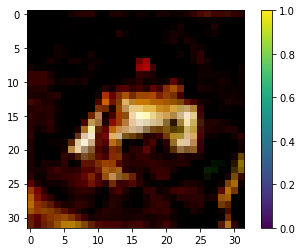

In [9]:
plt.imshow(train_x[0])
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

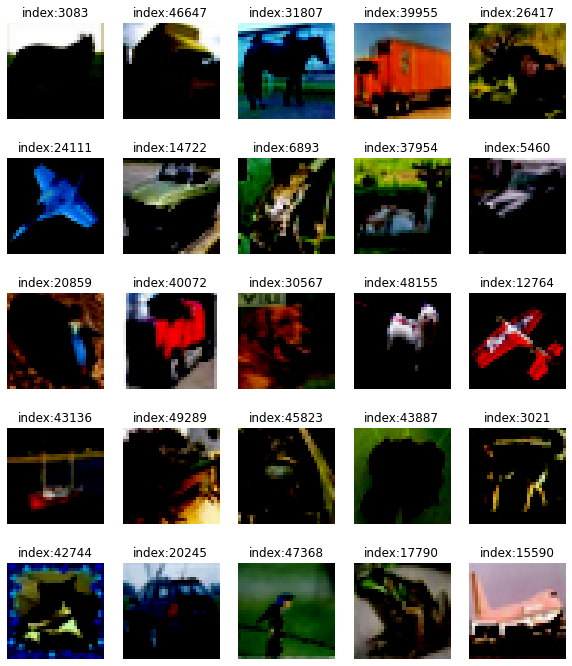

In [10]:
# 정규화한 학습데이터 시각화
plt.figure(figsize=(10, 12))

p = np.random.randint(0, 50000, size=25)

for i, v in enumerate(p):
    plt.subplot(5,5,i+1)
    plt.imshow(train_x[v])
    plt.title(f'index:{v}')
    plt.axis('off')
    
plt.show()

In [11]:
BUFFER_SIZE = 50000
BATCH_SIZE = 128

In [12]:
# 미니배치 데이터 셋 구성
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## STEP 2. 생성자 모델 구현하기

- (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성
- noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성
- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인

In [13]:
# define the standalone generator model
def make_generator_model():
    
    model = tf.keras.Sequential()
    # First: Dense layer
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False)) 
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(3, 3), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [14]:
# define the generator model
generator = make_generator_model()
# summarize the model
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              409600    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524288    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [15]:
# 모델 생성이 잘 되었나 확인
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

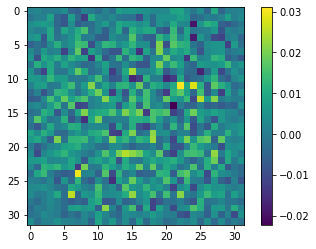

In [16]:
# 모델 생성이 잘 되었나 이미지 출력
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

## STEP 3. 판별자 모델 구현하기

- (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성
- 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인


In [17]:
# define the standalone discriminator model
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (3, 3), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Second: Conv2D Layer
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))
    
    return model

모델은 데이터 세트에서 샘플 이미지를 입력으로 가져와 샘플이 실제인지 가짜인지에 대한 분류 예측을 출력한다. 이진 분류 문제이다.

입력 : 3색 채널과 32 × 32 픽셀 크기의 이미지.  
출력 : 이진 분류, 샘플이 실제 (또는 가짜) 일 가능성.  
모델에는 일반 컨벌루션 레이어와 그 뒤로 입력 이미지를 다운 샘플링하기 위해 2x2 스트라이드를 사용하는 3개의 컨벌루션 레이어가 따른다. 입력 샘플이 실제인지 가짜인지를 예측하는 시그모이드 활성화 함수가 있는 출력 계층이 있다. 풀링 레이어를 사용하지 않고 유사한 다운 샘플링 효과를 얻기 위해 큰 보폭을 사용하도록 설계되었다. 이 모델은 이진 분류에 적합한 이진 교차 엔트로피 손실 함수를 최소화하도록 훈련된다. 

In [18]:
# define model
discriminator = make_discriminator_model()
# summarize the model
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)        

In [19]:
# 모델 생성이 잘 되었나 확인
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00052139]], dtype=float32)>

## STEP 4. 손실함수와 최적화 함수 구현하기

- 생성자와 판별자의 손실함수(loss)를 구현
- 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현
- 생성자와 판별자를 최적화하는 optimizer를 정의

In [20]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

생성자 손실함수

In [21]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

판별자 손실함수

In [22]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.constant(0.9, shape=real_output.shape), real_output) # 1.0 에서 0.9로 변경
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

이미지 판별 정확도 계산

In [23]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

최적화를 위한 optimizer

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [25]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## STEP 5. 훈련과정 상세 기능 구현하기

- 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현
- 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현
- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현
- training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정


In [26]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

train_step 함수를 하나하나 뜯어보면 다음과 같다.

(1) 입력데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음  
(2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함  
(3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기  
(4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성  
(5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력   
(6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산  
(7) accuracy 계산 : fake_output, real_output으로 discriminator가  
(8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산  
(9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신  
(10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴  

In [27]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        #plt.imshow(predictions[i, :, :, 0])
        np_generated = predictions[i].numpy()
        np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
        np_generated = np_generated.astype(int)
        plt.imshow(np_generated)
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [28]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [29]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## STEP 6. 학습 과정 진행하기  
- 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행
- 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현
- 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출

checkpoint를 통해 모델이 로드되었으면 아래 코드를 실행할 경우 로드된 모델의 파라미터 상태에서 훈련을 재개할 수도 있다.

In [26]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)  

In [27]:
save_every = 5
EPOCHS = 200

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

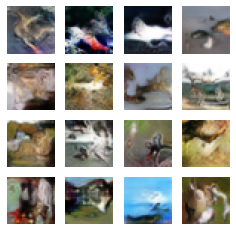

Time for training : 6242 sec


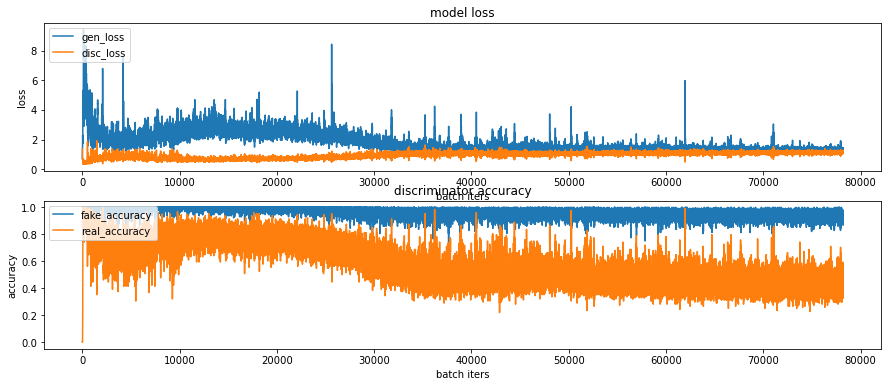

CPU times: user 1h 43min 18s, sys: 2min 5s, total: 1h 45min 23s
Wall time: 1h 44min 4s


In [28]:
%%time
train(train_dataset, EPOCHS, save_every)

/home/ssac6/aiffel/dcgan_newimage/cifar10/training_checkpoints/ckpt-40


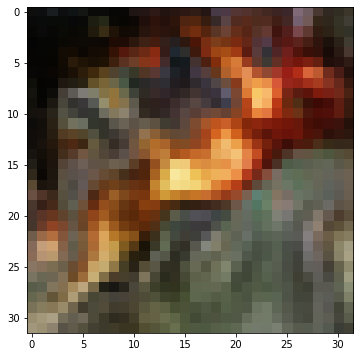

In [30]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_image_3.png'.format(os.getenv('HOME')))
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.


## 학습과정 시각화하기

In [29]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan.gif

-rw-r--r-- 1 ssac6 ssac6 3556870  2월 24 18:22 /home/ssac6/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan.gif


## STEP 7. (optional) GAN 훈련 과정 개선하기  
- STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석
- 모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출


### STEP 7-1. 문제점 분석

1. 학습이 진행되지 않고 멈춰있었다. 50epoch에서 중단했다.

<img src="./images/cifar10_mnist_dcgan.gif" width="450px" height="300px"></img>  
<img src="./images/generated_image.png" width="450px" height="300px"></img> 
<img src="./images/train_history_0049.png"></img> 
2. 출력이미지를 보기 위한 정규화를 돌려놓는 작업을 빠트렸다. 이미지가 잘 훈련되었는지 판단하기 힘들다.   
<img src="./images/cifar10_mnist_dcgan_2.gif" width="450px" height="300px"></img> 
<img src="./images/generated_image_1.png" width="450px" height="300px"></img>
<img src="./images/train_history_0199.png"></img>

### STEP 7-2. 개선하기  

1. 훈련이 더 이상 진행되지 않고 멈춰 있었는데, BatchNormalization 없이 수행했던 터라 BatchNormalization 을 추가하고, Learning Rate도 변경하는 등 모델을 수정하였다.  

2. 결과물을 확인하는 과정에서 정규화를 돌려놓는 작업이 없었는데, 추가하여 훈련과정을 확인할 있도록 하였다. 

3. 모델을 좀 더 개선하기 위해서 Tips from Goodfellow, NIPS 2016에서 언급한 내용중에 **One-sided label smoothing** 을 적용해 보았다.   

**One-sided label smoothing**의 핵심은 실제 데이터에 대한 target 값을 1보다 약간 작은 값, 이를테면 0.9로 해준다. 판별자가 실제 이미지를 감지하기 위해 미니 배치에 의존하는 경우 생성자는 판별자를 이용하기 위해서만 생성할 수 있다. 최적화가 너무 탐욕스러워지고, 장기적인 이점을 얻지 못할 수 있으므로 과신을 피하기 위해 실제 이미지에 대한 예측이 0.9를 초과 할 때 판별자에 패널티가 적용될 수 있도록 대상 레이블 값을 1.0이 아닌 0.9로 설정하여 수행한다.

discriminator_loss(real_output, fake_output) 함수에서 실제 이미지의 cross_entropy를 구할 때   
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) 에서   
    real_loss = cross_entropy(tf.constant(0.9, shape=real_output.shape), real_output) 로 변경하였다.    
    
    
<img src="./images/cifar10_mnist_dcgan_3.gif" width="450px" height="300px"></img> 
<img src="./images/generated_image_3.png" width="450px" height="300px"></img>


**100 epoch** 이하에서 accuracy가 높은 것으로 성능이 좋게 나왔지만, GAN을 수행하고, 결과물에 대한 판단은 정성적 판단이라 **200 epoch**의 결과물을 최종으로 제출하였다.  
<img src="./images/train_history_0199.png"></img> 

### STEP 7-3. 최종 이미지 출력

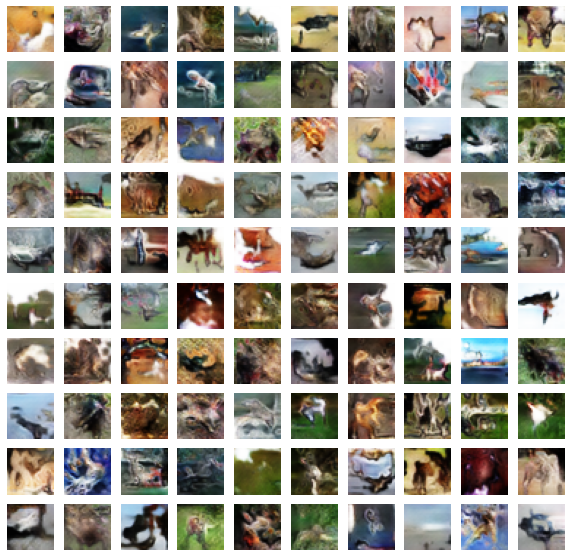

In [35]:
from numpy.random import randn

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# generate images
latent_points = generate_latent_points(100, 100)

predictions = generator(latent_points, training=False)

fig = plt.figure(figsize=(10, 10))
for i in range(predictions.shape[0]):
    plt.subplot(10, 10, i+1)
    #plt.imshow(predictions[i, :, :, 0])
    np_generated = predictions[i].numpy()
    np_generated = (np_generated * 127.5) + 127.5 # reverse of normalization
    np_generated = np_generated.astype(int)
    plt.imshow(np_generated)
    plt.axis('off')
plt.show()


## 느낀점  
GAN이 훈련하기가 힘들다고 들었는데, 정말로 학습이 되지 않고 멈춘 듯 했을 때 난감했다.  
데이터에 대한 차원을 이해하고 layer를 구성해야하는 것이 어려웠고,   
checkpoint를 사용해 모델 버전을 저장해놓을 수 있다는 걸 배워서 좋았다.    
모델이 복잡해지고 학습 속도가 오래 걸릴수록, 모델에 대한 저장 및 버전 관리는 필수적이라는 것을 깨달았다.   
성능개선에 많은 tip들이 있었지만, 한 개정도 밖에 적용해 보지 못했다.  
다음번에 다시 GAN을 배운다면 좀 더 세밀한 성능개선을 해보고 싶다.   

